In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet50
from torchvision.transforms import ToTensor, Resize

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tqdm.notebook import tqdm

from PIL import Image

from albumentations import *
from albumentations.pytorch import ToTensorV2

import timm
import transformers

import wandb

import os
from pathlib import Path
import random

/opt/conda/envs/mlenv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU

In [3]:
train_path = os.path.join(Path.home(), "input", "data", "train")
eval_path = os.path.join(Path.home(), "input", "data", "eval")

In [4]:
df_train = pd.read_csv(os.path.join(train_path, "train.csv"))
df_eval = pd.read_csv(os.path.join(eval_path, "info.csv"))

In [5]:
df_train_split = df_train.sample(frac=0.8, random_state=random_seed)
df_valid_split = df_train[~df_train.index.isin(df_train_split.index)]

In [6]:
## for test
class MaskDatasetTrain(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        all_images = []
        for path in df_train_split["path"]:
            image_path = os.path.join(train_path, "images", path)
            all_images += [os.path.join(image_path, image_filename) for image_filename in os.listdir(image_path) if image_filename[0] != "."]

        self.categories = {stat: i for i, stat in enumerate((Mask+Gender+Age) for Mask in ["Wear", "Incorrect", "NotWear"] for Gender in ["male", "female"] for Age in ["Under30", "30to60", "Overeq60"])}
        self.transform = transform

        category = []
        class_masked = []
        class_sex = []
        class_age = []
        for image_filename in all_images:
            *_, person_info, mask_info = image_filename.split(os.sep)
            id, sex, _, age = person_info.split('_')
            age = int(age)
            if mask_info[:-4] == "normal":
                mask_info = "NotWear"
            elif mask_info[:-4] == "incorrect_mask":
                mask_info = "Incorrect"
            else:
                mask_info = "Wear"
            
            if age < 30:
                age = "Under30"
            elif age >= 60:
                age = "Overeq60"
            else:
                age = "30to60"
                
            category.append(self.categories[mask_info+sex+age])
            
            class_masked.append(mask_info)
            class_sex.append(sex)
            class_age.append(age)
            
        self.train_Xy = pd.DataFrame(data=[all_images, category, class_masked, class_sex, class_age]).transpose()
        # self.train_Xy.columns = ["image_path", "class", "masked", "sex", "age"]
        self.train_Xy = self.train_Xy.to_numpy()
        
    def __getitem__(self, idx):
        image = Image.open(self.train_Xy[idx][0])
        if self.transform is not None:
            image = self.transform(image=np.array(image))
        label = self.train_Xy[idx][1]
        return image["image"], label

    def __len__(self):
        return len(self.train_Xy)
    
class MaskDatasetValid(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        all_images = []
        for path in df_valid_split["path"]:
            image_path = os.path.join(train_path, "images", path)
            all_images += [os.path.join(image_path, image_filename) for image_filename in os.listdir(image_path) if image_filename[0] != "."]

        self.categories = {stat: i for i, stat in enumerate((Mask+Gender+Age) for Mask in ["Wear", "Incorrect", "NotWear"] for Gender in ["male", "female"] for Age in ["Under30", "30to60", "Overeq60"])}
        self.transform = transform

        category = []
        class_masked = []
        class_sex = []
        class_age = []
        for image_filename in all_images:
            *_, person_info, mask_info = image_filename.split(os.sep)
            id, sex, _, age = person_info.split('_')
            age = int(age)
            if mask_info[:-4] == "normal":
                mask_info = "NotWear"
            elif mask_info[:-4] == "incorrect_mask":
                mask_info = "Incorrect"
            else:
                mask_info = "Wear"
            
            if age < 30:
                age = "Under30"
            elif age >= 60:
                age = "Overeq60"
            else:
                age = "30to60"
                
            category.append(self.categories[mask_info+sex+age])
            
            class_masked.append(mask_info)
            class_sex.append(sex)
            class_age.append(age)
            
        self.train_Xy = pd.DataFrame(data=[all_images, category, class_masked, class_sex, class_age]).transpose()
        # self.train_Xy.columns = ["image_path", "class", "masked", "sex", "age"]
        self.train_Xy = self.train_Xy.to_numpy()
        
    def __getitem__(self, idx):
        image = Image.open(self.train_Xy[idx][0])
        if self.transform is not None:
            image = self.transform(image=np.array(image))
        label = self.train_Xy[idx][1]
        return image["image"], label

    def __len__(self):
        return len(self.train_Xy)

In [7]:
class MaskDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        all_images = []
        for path in df_train["path"]:
            image_path = os.path.join(train_path, "images", path)
            all_images += [os.path.join(image_path, image_filename) for image_filename in os.listdir(image_path) if image_filename[0] != "."]

        self.categories = {stat: i for i, stat in enumerate((Mask+Gender+Age) for Mask in ["Wear", "Incorrect", "NotWear"] for Gender in ["male", "female"] for Age in ["Under30", "30to60", "Overeq60"])}
        self.transform = transform

        category = []
        class_masked = []
        class_sex = []
        class_age = []
        for image_filename in all_images:
            *_, person_info, mask_info = image_filename.split(os.sep)
            id, sex, _, age = person_info.split('_')
            age = int(age)
            if mask_info[:-4] == "normal":
                mask_info = "NotWear"
            elif mask_info[:-4] == "incorrect_mask":
                mask_info = "Incorrect"
            else:
                mask_info = "Wear"
            
            if age < 30:
                age = "Under30"
            elif age >= 60:
                age = "Overeq60"
            else:
                age = "30to60"
                
            category.append(self.categories[mask_info+sex+age])
            
            class_masked.append(mask_info)
            class_sex.append(sex)
            class_age.append(age)
            
        self.train_Xy = pd.DataFrame(data=[all_images, category, class_masked, class_sex, class_age]).transpose()
        # self.train_Xy.columns = ["image_path", "class", "masked", "sex", "age"]
        self.train_Xy = self.train_Xy.to_numpy()
        
    def __getitem__(self, idx):
        image = Image.open(self.train_Xy[idx][0])
        if self.transform is not None:
            image = self.transform(image=np.array(image))
        label = self.train_Xy[idx][1]
        return image["image"], label

    def __len__(self):
        return len(self.train_Xy)

In [8]:
class MaskDatasetEval(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.df_eval = pd.read_csv(os.path.join(eval_path, "info.csv"))
        self.eval_image_path = os.path.join(eval_path, "images")
        self.transform = transform
        
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.eval_image_path, self.df_eval['ImageID'][idx]))
        if self.transform:
            image = self.transform(image=np.array(image))
        return image["image"], self.df_eval['ImageID'][idx]

    def __len__(self):
        return len(self.df_eval)

In [9]:
mean = [0.56019265, 0.52410305, 0.50145299]
std = [0.23308824, 0.24294489, 0.2456003]

In [129]:
# transform = torchvision.transforms.Compose([
#     ToTensor(),
# ])
transform = Compose([
    # HorizontalFlip(p=0.2),
    CenterCrop(350, 250, p=1.0),
    RandomBrightnessContrast(contrast_limit=(0.2, 0.8), p=0.2),
    # GaussNoise(var_limit=(1000, 1600), p=0.3),
    Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0)
], p=1.0)

transform_val = Compose([
    CenterCrop(350, 250, p=1.0),
    Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0)
], p=1.0)

In [130]:
# ds = MaskDataset(transform=None)
ds_eval = MaskDatasetEval(transform=transform_val)

In [108]:
# train_ds, test_ds = train_test_split(ds, test_size=0.2, stratify=list(range(18)))
# train_ds, valid_ds = random_split(ds, [int(len(ds)*0.8), int(len(ds)*0.2)])

In [109]:
# train_ds.dataset.transform = transform
# valid_ds.dataset.transform = transform_val

In [131]:
train_ds = MaskDatasetTrain(transform=transform)
valid_ds = MaskDatasetValid(transform=transform_val)

# train_ds = MaskDatasetTrain(transform=torchvision.transforms.Compose([ToTensor()]))
# valid_ds = MaskDatasetValid(transform=torchvision.transforms.Compose([ToTensor()]))

In [132]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, drop_last=True)
valid_dataloader = DataLoader(valid_ds, batch_size=32, shuffle=True, num_workers=4, drop_last=True)

In [133]:
model = resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=18)

# model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=18)

# model = timm.create_model('tf_efficientnet_b7_ns', pretrained=True, num_classes=18)

# from transformers import ViTModel, ViTFeatureExtractor
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-huge-patch14-224-in21k')
# model = ViTModel.from_pretrained('google/vit-huge-patch14-224-in21k')
# out = feature_extractor(images=torch.rand(16, 3, 256, 256), return_tensors="pt")
# outputs = model(**out)
# last_hidden_states = outputs.last_hidden_state

In [137]:
class ThreeClassification(nn.Module):
    def __init__(self):
        super(ThreeClassification, self).__init__()
        self.mask_model = resnet50(pretrained=True)
        self.mask_model.fc = nn.Linear(2048, 3)
        
        self.gender_model = resnet50(pretrained=True)
        self.gender_model.fc = nn.Linear(2048, 2)
        
        self.age_model = resnet50(pretrained=True)
        self.age_model.fc = nn.Linear(2048, 3)
    
    def forward(self, x):
        mask_out = self.mask_model(x)
        gender_out = self.gender_model(x)
        age_out = self.age_model(x)
        
        return [mask_out, gender_out, age_out]

In [134]:
torch.cuda.empty_cache()

import gc
gc.collect()

3172

In [135]:
class F1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

In [136]:
wandb.init(
    project="MaskClassification",
    
    config={
        "learning_rate": 5e-6,
        "architecture": "EfficientNetb7NS",
        "epochs": 50,
        "scheduler": "ReduceLROnPlateau"
    }
)
wandb.run.name = "resnet50-togray"

device = "cuda" if torch.cuda.is_available() else "cpu"

epoch = 50
epoch_start=1
patience = 10
best_loss = -np.inf
counter = 0
start_from_checkpoint=False

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, threshold=1e-3)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = F1Loss(classes=18)

train_loss_list = []
val_loss_list = []
val_metric_list = []

"""
"epoch": i,
"model_state_dict": model.state_dict(),
"optimizer_state_dict": optimizer.state_dict(),
"earlystop_bestloss": best_loss,
"earlystop_counter": counter,
"train_losslist": train_loss_list,
"val_losslist": val_loss_list,
"val_metrics": val_metric_list
"""
if start_from_checkpoint:
    checkpoint_name = "checkpoint/epoch13_met0.9933840502285781"
    checkpoint = torch.load(checkpoint_name)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch_start = checkpoint["epoch"] + 1
    best_loss = checkpoint["earlystop_bestloss"]
    counter = checkpoint["earlystop_counter"]
    train_loss_list = checkpoint["train_losslist"]
    val_loss_list = checkpoint["val_losslist"]
    val_metric_list = checkpoint["val_metrics"]

for i in range(epoch_start, epoch):
    print("---------------------------------------")
    print(f"epoch {i}")
    model.train()
    metric_logger = {}
    acc = 0
    total_loss = 0
    pred_list = None
    y_list = None
    for X, y in tqdm(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred_onehot = pred.argmax(dim=1)
        acc += sum(pred_onehot == y) / X.shape[0]
        total_loss += loss.item()
        
        if pred_list is not None:
            pred_list = torch.cat((pred_list, pred_onehot))
            y_list = torch.cat((y_list, y))
        else:
            pred_list = pred_onehot
            y_list = y
    print(f"train loss : {total_loss/len(train_dataloader)}, acc : {acc/len(train_dataloader) * 100}%", end=" ")
    print("f1 score : ", f1_score(y_list.cpu(), pred_list.cpu(), labels=list(range(18)), average='weighted'))
    train_loss_list.append(total_loss/len(train_dataloader))
    metric_logger["train_loss"] = total_loss/len(train_dataloader)
    metric_logger["train_acc"] = acc/len(train_dataloader) * 100
    metric_logger["train_f1"] = f1_score(y_list.cpu(), pred_list.cpu(), labels=list(range(18)), average='weighted')
    
    model.eval()
    acc = 0
    total_loss = 0
    pred_list = None
    y_list = None
    with torch.no_grad():
        for X, y in tqdm(valid_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            pred_onehot = pred.argmax(dim=1)
            loss = loss_fn(pred, y).item()
            acc += sum(pred_onehot == y) / X.shape[0]
            total_loss += loss
            
            if pred_list is not None:
                pred_list = torch.cat((pred_list, pred_onehot))
                y_list = torch.cat((y_list, y))
            else:
                pred_list = pred_onehot
                y_list = y
    total_loss = total_loss/len(valid_dataloader)
    val_f1 = f1_score(y_list.cpu(), pred_list.cpu(), labels=list(range(18)), average='weighted')
    print(f"val loss : {total_loss}, acc : {acc/len(valid_dataloader) * 100}%, f1 score : {val_f1}")
    scheduler.step(total_loss)
    metric_logger["val_loss"] = total_loss
    metric_logger["val_acc"] = acc/len(valid_dataloader) * 100
    metric_logger["val_f1"] = val_f1
    wandb.log(metric_logger)
    val_loss_list.append(val_f1)
    val_metric_list.append(val_f1)
    
    torch.save({
        "epoch": i,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "earlystop_bestloss": best_loss,
        "earlystop_counter": counter,
        "train_losslist": train_loss_list,
        "val_losslist": val_loss_list,
        "val_metrics": val_metric_list
    }, os.path.join("checkpoint", f"epoch{i}_met{val_metric_list[-1]}"))
    
    earlystop_loss = val_f1
    if best_loss < earlystop_loss:
        print(f"validation loss improved. {best_loss}->{earlystop_loss}")
        best_loss = earlystop_loss
        counter = 0
        torch.save(model.state_dict(), os.path.join("checkpoint", "best.pt"))
    else:
        counter += 1
    if counter == patience:
        print(f"No validation improvement until {patience} iteration. Stopping.")
        break
    
    print("")
    
best_checkpoint = torch.load("checkpoint/best.pt")
model.load_state_dict(best_checkpoint)

---------------------------------------
epoch 1



train loss : 2.2696551046634124, acc : 35.23569869995117% f1 score :  0.37279730101731656



val loss : 1.3005157476764615, acc : 62.31461715698242%, f1 score : 0.5983217407531772
validation loss improved. -inf->0.5983217407531772

---------------------------------------
epoch 2



train loss : 1.0837449625260749, acc : 68.45206451416016% f1 score :  0.6575024693772668



val loss : 0.8368951557046276, acc : 75.45021057128906%, f1 score : 0.7391148452565133
validation loss improved. 0.5983217407531772->0.7391148452565133

---------------------------------------
epoch 3



train loss : 0.7646969965959, acc : 76.86043548583984% f1 score :  0.7522696879188131



val loss : 0.6580066842547918, acc : 79.92584991455078%, f1 score : 0.7901960044556803
validation loss improved. 0.7391148452565133->0.7901960044556803

---------------------------------------
epoch 4



train loss : 0.5984323992693829, acc : 81.89221954345703% f1 score :  0.8068519770117858



val loss : 0.557120405895225, acc : 82.70657348632812%, f1 score : 0.8200842805402042
validation loss improved. 0.7901960044556803->0.8200842805402042

---------------------------------------
epoch 5



train loss : 0.4902274885956766, acc : 84.69941711425781% f1 score :  0.8382160249806939



val loss : 0.4956666192008277, acc : 84.4544448852539%, f1 score : 0.8404908640228026
validation loss improved. 0.8200842805402042->0.8404908640228026

---------------------------------------
epoch 6



train loss : 0.41838274596227426, acc : 86.77833557128906% f1 score :  0.8611269271592156



val loss : 0.4571627989663916, acc : 85.0105972290039%, f1 score : 0.8460791589772558
validation loss improved. 0.8404908640228026->0.8460791589772558

---------------------------------------
epoch 7



train loss : 0.36728835667846566, acc : 88.41366577148438% f1 score :  0.8794220049318671



val loss : 0.4230295811164177, acc : 86.06991577148438%, f1 score : 0.8575683971812538
validation loss improved. 0.8460791589772558->0.8575683971812538

---------------------------------------
epoch 8



train loss : 0.3195063574397463, acc : 89.78416442871094% f1 score :  0.8942524909602614



val loss : 0.4008204460270324, acc : 86.73199462890625%, f1 score : 0.8648356212680999
validation loss improved. 0.8575683971812538->0.8648356212680999

---------------------------------------
epoch 9



train loss : 0.28865353508173663, acc : 90.44624328613281% f1 score :  0.9015448855440515



val loss : 0.38561306110883165, acc : 87.36758422851562%, f1 score : 0.8732250727013309
validation loss improved. 0.8648356212680999->0.8732250727013309

---------------------------------------
epoch 10



train loss : 0.25977255141962385, acc : 91.49231719970703% f1 score :  0.91271946895153



val loss : 0.3727730617432271, acc : 87.5%, f1 score : 0.874431743553272
validation loss improved. 0.8732250727013309->0.874431743553272

---------------------------------------
epoch 11



train loss : 0.22761832445196933, acc : 92.47881317138672% f1 score :  0.9229079849368829



val loss : 0.3612099144670923, acc : 88.18856048583984%, f1 score : 0.8812876777552906
validation loss improved. 0.874431743553272->0.8812876777552906

---------------------------------------
epoch 12



train loss : 0.2001034560834326, acc : 93.74337768554688% f1 score :  0.9359436224635314



val loss : 0.3575257161726891, acc : 88.16207885742188%, f1 score : 0.8810212553021293

---------------------------------------
epoch 13



train loss : 0.18151178394870485, acc : 94.31275939941406% f1 score :  0.9419604414427898



val loss : 0.3495038615823802, acc : 88.6387710571289%, f1 score : 0.8859888174579269
validation loss improved. 0.8812876777552906->0.8859888174579269

---------------------------------------
epoch 14



train loss : 0.16575748171909885, acc : 94.9549789428711% f1 score :  0.9486672242786204



val loss : 0.3448246853205107, acc : 88.69173431396484%, f1 score : 0.887051803989684
validation loss improved. 0.8859888174579269->0.887051803989684

---------------------------------------
epoch 15



train loss : 0.1461941320409651, acc : 95.69650268554688% f1 score :  0.9562755828711914



val loss : 0.3431232810904414, acc : 88.79766845703125%, f1 score : 0.8877638911832304
validation loss improved. 0.887051803989684->0.8877638911832304

---------------------------------------
epoch 16



train loss : 0.13058043025449803, acc : 96.22616577148438% f1 score :  0.9617369800404624



val loss : 0.34075850374617817, acc : 88.85063171386719%, f1 score : 0.8881189917578424
validation loss improved. 0.8877638911832304->0.8881189917578424

---------------------------------------
epoch 17



train loss : 0.12340535436977901, acc : 96.47775268554688% f1 score :  0.9642785059225129



val loss : 0.33651597374829195, acc : 89.40678405761719%, f1 score : 0.8938897414924879
validation loss improved. 0.8881189917578424->0.8938897414924879

---------------------------------------
epoch 18



train loss : 0.10646433858753387, acc : 97.10010528564453% f1 score :  0.9706776597645942



val loss : 0.3406421774209051, acc : 89.00953674316406%, f1 score : 0.8908930167000926

---------------------------------------
epoch 19



train loss : 0.09843394460582758, acc : 97.35831451416016% f1 score :  0.9732945194620651



val loss : 0.3404965159814742, acc : 89.30084991455078%, f1 score : 0.893613846774481

---------------------------------------
epoch 20



train loss : 0.08839252632766394, acc : 97.63639068603516% f1 score :  0.9761014073604176



val loss : 0.3451797609864655, acc : 89.1419448852539%, f1 score : 0.8929040906879853

---------------------------------------
epoch 21



train loss : 0.08054652842850882, acc : 97.94094848632812% f1 score :  0.9792532167305331



val loss : 0.3478226729558181, acc : 89.1419448852539%, f1 score : 0.8918052265663727

---------------------------------------
epoch 22



train loss : 0.071156723113036, acc : 98.324951171875% f1 score :  0.9831124754982741



val loss : 0.3456812071598182, acc : 89.19491577148438%, f1 score : 0.8924716715104776

---------------------------------------
epoch 23



train loss : 0.06832546561214504, acc : 98.48384094238281% f1 score :  0.9847472523227525



val loss : 0.34579263693826684, acc : 89.24787902832031%, f1 score : 0.8938233848181976

---------------------------------------
epoch 24



train loss : 0.06517777167718415, acc : 98.45735931396484% f1 score :  0.9845037505163662



val loss : 0.34694484971716244, acc : 89.61864471435547%, f1 score : 0.8965367979212421
validation loss improved. 0.8938897414924879->0.8965367979212421

---------------------------------------
epoch 25



train loss : 0.061168472172092585, acc : 98.56329345703125% f1 score :  0.9855669321679505



val loss : 0.35057074062021104, acc : 89.35381317138672%, f1 score : 0.8947940481074661

---------------------------------------
epoch 26



train loss : 0.057713769249996896, acc : 98.70895385742188% f1 score :  0.9870489984483917



val loss : 0.3496041905324338, acc : 89.24787902832031%, f1 score : 0.893035163527406

---------------------------------------
epoch 27



train loss : 0.052631950733977986, acc : 98.94729614257812% f1 score :  0.9894187254596489



val loss : 0.3523440101199736, acc : 89.43326568603516%, f1 score : 0.8956093328538561

---------------------------------------
epoch 28



train loss : 0.05538261774927378, acc : 98.828125% f1 score :  0.9882406765207435



val loss : 0.347878906781138, acc : 89.75106048583984%, f1 score : 0.8975936036924798
validation loss improved. 0.8965367979212421->0.8975936036924798

---------------------------------------
epoch 29



train loss : 0.052962975877423976, acc : 98.90095520019531% f1 score :  0.9889714581809804



val loss : 0.3528763962183463, acc : 89.38029479980469%, f1 score : 0.8948619395518753

---------------------------------------
epoch 30



train loss : 0.051572146298663725, acc : 98.9075698852539% f1 score :  0.9890276181753918



val loss : 0.3542825137975357, acc : 89.32733154296875%, f1 score : 0.8948714126466185

---------------------------------------
epoch 31



train loss : 0.05079687361297655, acc : 99.0730972290039% f1 score :  0.9907003660189168



val loss : 0.3548598097226882, acc : 89.11546325683594%, f1 score : 0.8926949290670658

---------------------------------------
epoch 32



train loss : 0.05063639974351814, acc : 98.84798431396484% f1 score :  0.9884070355263315



val loss : 0.3502927741067389, acc : 89.64512634277344%, f1 score : 0.8961590192267403

---------------------------------------
epoch 33



train loss : 0.04948215036143912, acc : 98.92081451416016% f1 score :  0.9891741209342125



val loss : 0.34990606198118906, acc : 89.32733154296875%, f1 score : 0.894117121920549

---------------------------------------
epoch 34



train loss : 0.05107253057274462, acc : 98.85460662841797% f1 score :  0.9885217152723128



val loss : 0.3505623548023276, acc : 89.53919219970703%, f1 score : 0.8960624810759839

---------------------------------------
epoch 35



train loss : 0.047149082679317285, acc : 99.05985260009766% f1 score :  0.9905778438770385



val loss : 0.3489935115232306, acc : 89.83050537109375%, f1 score : 0.8986946314348773
validation loss improved. 0.8975936036924798->0.8986946314348773

---------------------------------------
epoch 36



train loss : 0.04631750124814463, acc : 99.11943817138672% f1 score :  0.9911716324622205



val loss : 0.34736334756648135, acc : 89.77754211425781%, f1 score : 0.8978596073885359

---------------------------------------
epoch 37



train loss : 0.04839791567064822, acc : 98.98702239990234% f1 score :  0.989842093383891



val loss : 0.356088333131777, acc : 89.51271057128906%, f1 score : 0.8959145306264316

---------------------------------------
epoch 38



train loss : 0.04890642331625035, acc : 98.89433288574219% f1 score :  0.9889102685756269



val loss : 0.3550536026862466, acc : 89.22139739990234%, f1 score : 0.8934227215299582

---------------------------------------
epoch 39



train loss : 0.047123165769597235, acc : 99.106201171875% f1 score :  0.9910389993454415



val loss : 0.35086802049082216, acc : 89.565673828125%, f1 score : 0.8960763173038245

---------------------------------------
epoch 40



train loss : 0.04811001702417004, acc : 98.940673828125% f1 score :  0.9893716644384962



val loss : 0.3483703745118642, acc : 89.67161560058594%, f1 score : 0.897296404630144

---------------------------------------
epoch 41



train loss : 0.04855594083654963, acc : 98.98702239990234% f1 score :  0.9898489629958317



val loss : 0.3526517664382266, acc : 89.45974731445312%, f1 score : 0.8952187966903484

---------------------------------------
epoch 42



train loss : 0.04637344831095661, acc : 99.106201171875% f1 score :  0.9910173807922291



val loss : 0.35132999986536423, acc : 89.45974731445312%, f1 score : 0.8955976938216983

---------------------------------------
epoch 43



train loss : 0.04583694544912837, acc : 99.09295654296875% f1 score :  0.9909039911939336



val loss : 0.3551360925785818, acc : 89.19491577148438%, f1 score : 0.893441614589081

---------------------------------------
epoch 44



train loss : 0.046676245498297325, acc : 99.02674865722656% f1 score :  0.9902317497050391



val loss : 0.3564156797888168, acc : 89.0625%, f1 score : 0.8920013070458951

---------------------------------------
epoch 45



train loss : 0.04462779487652894, acc : 99.14591979980469% f1 score :  0.9914421020477766



val loss : 0.35557986385488916, acc : 89.35381317138672%, f1 score : 0.8944323959459614
No validation improvement until 10 iteration. Stopping.


<All keys matched successfully>

-----------------------------

## best model load, validation eval

In [87]:
model = resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=18)

# model = timm.create_model('efficientnet_b0', pretrained=True)
# model.classifier = nn.Linear(1280, 18)

In [88]:
device = "cuda"
best_checkpoint = torch.load("saved/resnet50-contrast.pt")
model.load_state_dict(best_checkpoint)
model = model.to(device)

In [89]:
loss_fn = nn.CrossEntropyLoss()
model.eval()
acc = 0
total_loss = 0
pred_list = None
y_list = None
with torch.no_grad():
    for X, y in tqdm(valid_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        
        pred_onehot = pred.argmax(dim=1)
        loss = loss_fn(pred, y).item()
        acc += sum(pred_onehot == y) / X.shape[0]
        total_loss += loss
        
        if pred_list is not None:
            pred_list = torch.cat((pred_list, pred_onehot))
            y_list = torch.cat((y_list, y))
        else:
            pred_list = pred_onehot
            y_list = y
total_loss = total_loss/len(valid_dataloader)
val_f1 = f1_score(y_list.cpu(), pred_list.cpu(), labels=list(range(18)), average='weighted')
print(f"val loss : {total_loss}, acc : {acc/len(valid_dataloader) * 100}%, f1 score : {val_f1}")


val loss : 0.2919119256311807, acc : 92.55826568603516%, f1 score : 0.9240675192093508


----------------------------

## Submission만들기

In [78]:
id_list = []
pred_list = []
model.eval()
with torch.no_grad():
    for img, id in tqdm(ds_eval):
        pred = model(img.unsqueeze(dim=0).cuda()).argmax(dim=1).item()
        id_list.append(id)
        pred_list.append(pred)

KeyError: 12600

In [79]:
submission = pd.DataFrame(list(zip(id_list, pred_list)), columns = ["ImageID", "ans"])
submission.to_csv("submission3.csv", index=False)

In [80]:
unique, counts = np.unique(np.array(pred_list), return_counts=True)
print({u: c for u, c in zip(unique, counts)})

{0: 2366, 1: 2727, 2: 434, 3: 1481, 4: 1687, 5: 304, 6: 465, 7: 547, 8: 97, 9: 299, 10: 342, 11: 55, 12: 468, 13: 542, 14: 97, 15: 297, 16: 335, 17: 57}


## Submission peek

In [81]:
train_ds.categories

{'WearmaleUnder30': 0,
 'Wearmale30to60': 1,
 'WearmaleOvereq60': 2,
 'WearfemaleUnder30': 3,
 'Wearfemale30to60': 4,
 'WearfemaleOvereq60': 5,
 'IncorrectmaleUnder30': 6,
 'Incorrectmale30to60': 7,
 'IncorrectmaleOvereq60': 8,
 'IncorrectfemaleUnder30': 9,
 'Incorrectfemale30to60': 10,
 'IncorrectfemaleOvereq60': 11,
 'NotWearmaleUnder30': 12,
 'NotWearmale30to60': 13,
 'NotWearmaleOvereq60': 14,
 'NotWearfemaleUnder30': 15,
 'NotWearfemale30to60': 16,
 'NotWearfemaleOvereq60': 17}

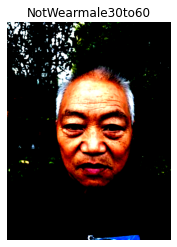

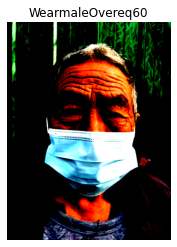

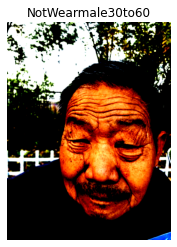

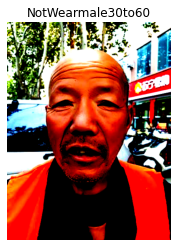

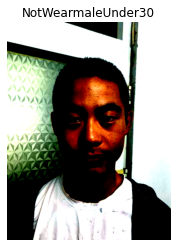

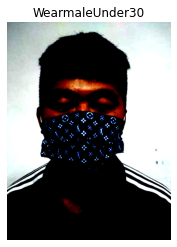

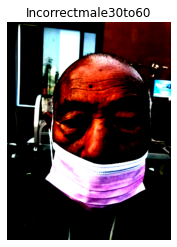

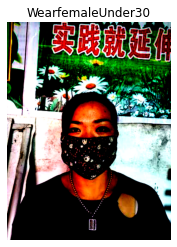

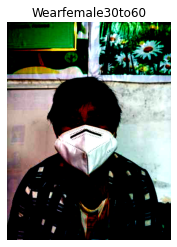

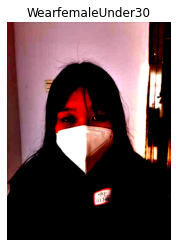

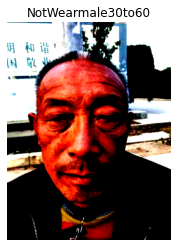

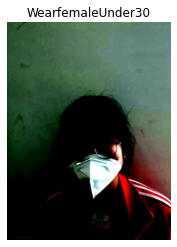

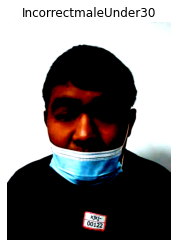

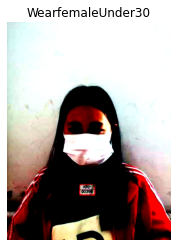

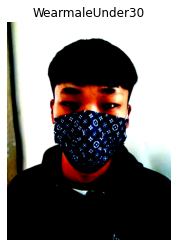

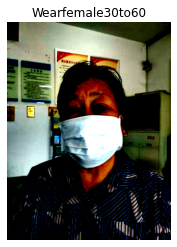

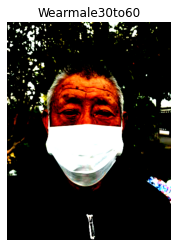

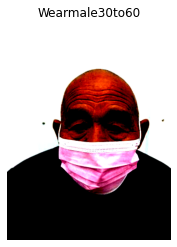

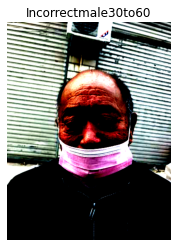

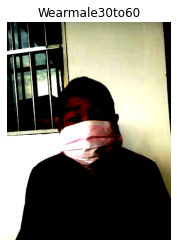

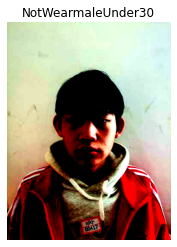

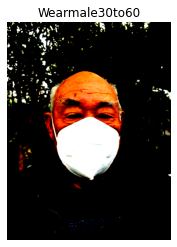

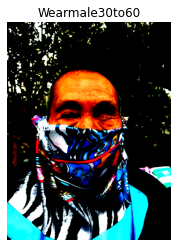

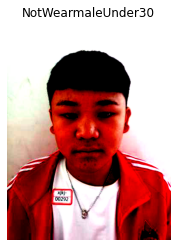

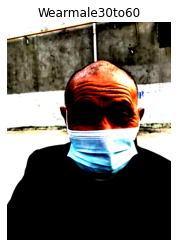

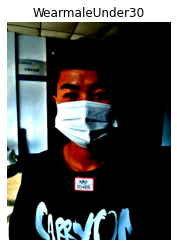

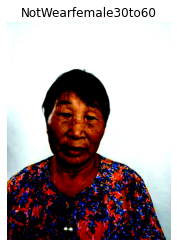

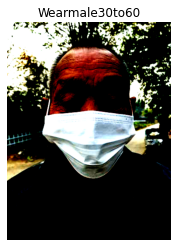

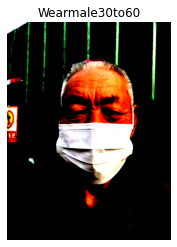

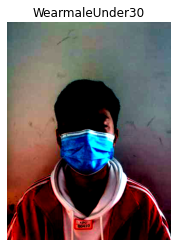

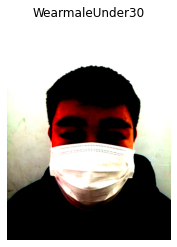

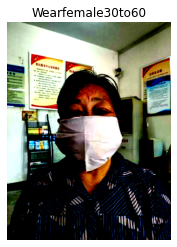

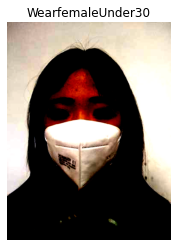

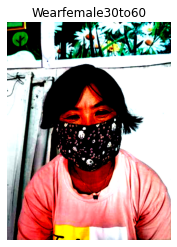

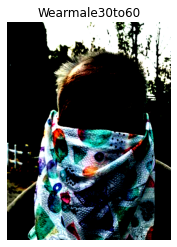

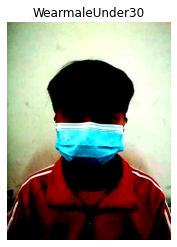

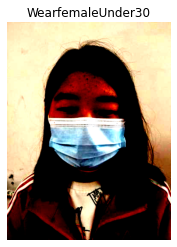

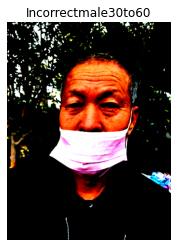

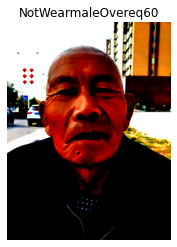

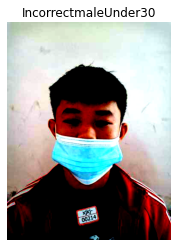

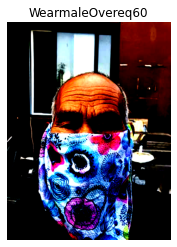

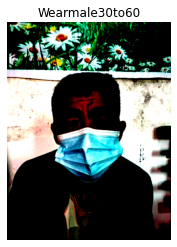

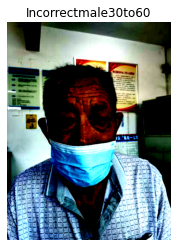

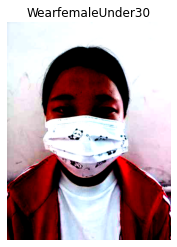

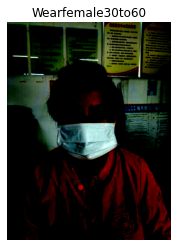

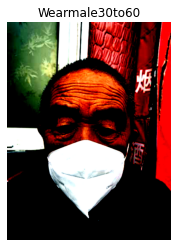

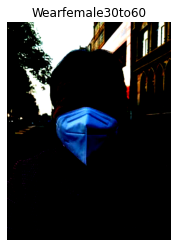

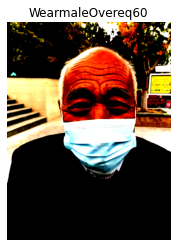

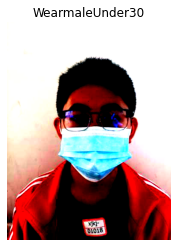

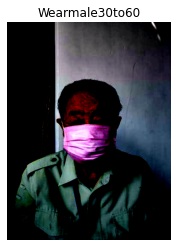

In [82]:
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
# plotting code here

with torch.no_grad():
    for i, (img, id) in enumerate(tqdm(ds_eval)):
        pred = model(img.unsqueeze(dim=0).cuda()).argmax(dim=1).item()
        # plt.subplot(2, 10, i+1)
        plt.axis("off")
        plt.title(list(train_ds.categories.keys())[list(train_ds.categories.values()).index(pred)])
        plt.imshow(img.permute(1, 2, 0))
        plt.show()
        if i == 49:
            break
logger.setLevel(old_level)

------------------

## validation wrong prediction 확인

In [ ]:
target = []
prediction = []
with torch.no_grad():
    for X, y in tqdm(valid_dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        pred = pred.argmax(dim=1)
        indices = (pred != y).nonzero().squeeze()
        if indices.nelement() != 0:
            target.append(X[indices])
            prediction.append((pred[indices], y[indices]))

<ipython-input-21-35a40890541c>:9: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  indices = (pred != y).nonzero().squeeze()


In [ ]:
len(target)

20

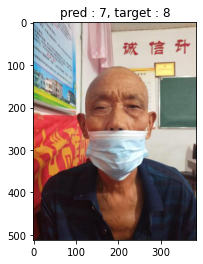

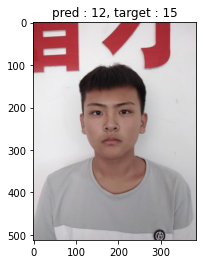

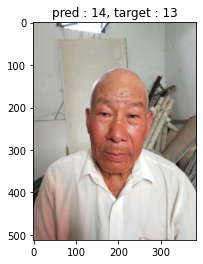

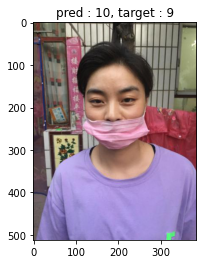

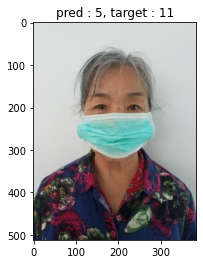

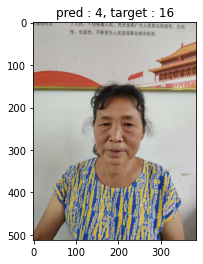

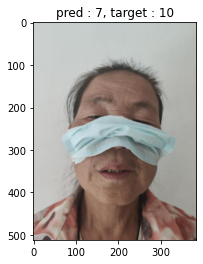

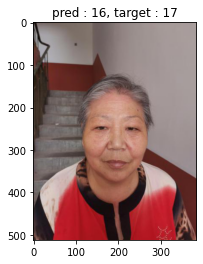

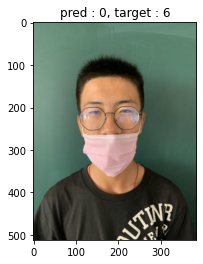

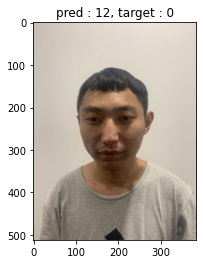

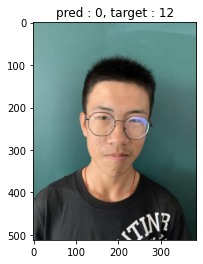

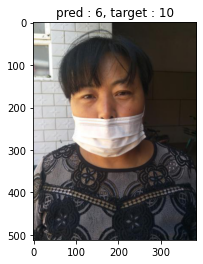

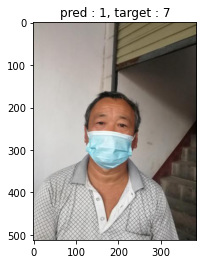

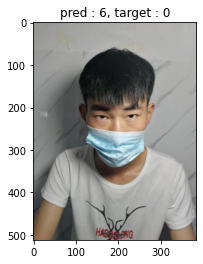

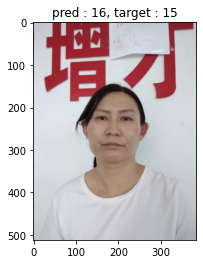

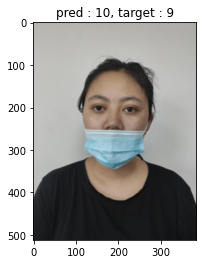

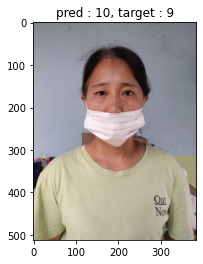

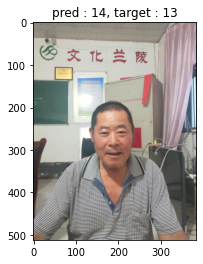

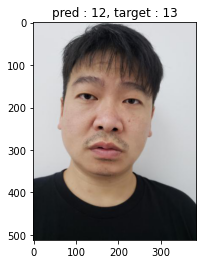

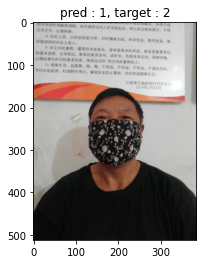

In [ ]:
i = 1
for img, (pred, targ) in zip(target, prediction):
    if len(img.shape) == 4:
        for img_sep, p, t in zip(img, pred, targ):
            plt.title(f"pred : {p.item()}, target : {t.item()}")
            plt.imshow(img_sep.cpu().permute(1, 2, 0))
            plt.show()
    else:
        plt.title(f"pred : {pred.item()}, target : {targ.item()}")
        plt.imshow(img.cpu().permute(1, 2, 0))
        plt.show()
    i+=1

In [ ]:
sub1 = pd.read_csv("submission.csv")
sub2 = pd.read_csv("submission0.csv")

In [ ]:
(sub1['ans'] == sub2['ans']).value_counts()

True     11130
False     1470
Name: ans, dtype: int64

In [ ]:
out = sub1['ans'].compare(sub2['ans'])

In [ ]:
out

Empty DataFrame
Columns: [self, other]
Index: []